In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (5.0,4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

In [5]:
def zero_pad(X,pad):

 X_pad = np.pad(X, ((0,0), (pad,pad),(pad,pad),(0,0)), 'constant', constant_values=0)

 return X_pad  

x.shape= (4, 3, 3, 2)
x_pad.shape= (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


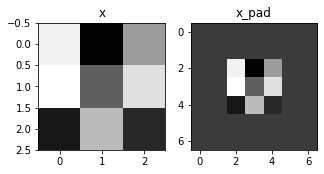

In [6]:
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_pad = zero_pad(x,2)

print("x.shape=", x.shape)
print("x_pad.shape=", x_pad.shape)
print("x[1,1] =", x[1,1])
print("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1,2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])



In [7]:
def conv_single_step(a_slice_prev, W,b):
  s = np.multiply(a_slice_prev, W)
  Z = np.sum(s)
  Z += float(b)

  return Z

In [8]:
np.random.seed(1)

a_slice_prev = np.random.randn(4,4,3)
W = np.random.randn(4,4,3)
b = np.random.randn(1,1,1)

Z = conv_single_step(a_slice_prev,W,b)

print("Z = ", Z)

Z =  -6.999089450680221


### Forward Propogation Algorithm

In [9]:
def conv_forward(A_prev, W, b, hparameters):
  (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
  (f,f,n_C_prev, n_C) = W.shape

  stride = hparameters['stride']
  pad = hparameters['pad']

  n_H = int(((n_H_prev - f+2*pad)/stride)+1)
  n_W = int(((n_W_prev - f+2*pad)/stride)+1)

  Z = np.zeros([m,n_H,n_W,n_C])

  A_prev_pad = zero_pad(A_prev, pad)

  for i in range(m):
    a_prev_pad = A_prev_pad[i]
    for h in range(n_H):
      for w in range(n_W):
        for c in range(n_C):

          vert_start = h*stride
          vert_end = vert_start + f
          horiz_start = w*stride
          horiz_end = horiz_start + f

          a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end]

          Z[i,h,w,c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])

  assert(Z.shape == (m, n_H, n_W, n_C))

  cache = (A_prev, W, b, hparameters)

  return Z, cache

In [10]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)

hparameters = {"pad" :2,
              "stride" :2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

print("Avg. of Z= ", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Avg. of Z=  0.048995203528855794
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [11]:
def pool_forward(A_prev, hparameters,mode = "max"):
  
  (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
  
  f = hparameters["f"]
  stride = hparameters["stride"]
  
  n_H = int(1 + (n_H_prev -f)/ stride)
  n_W = int(1 + (n_W_prev -f)/ stride)
  n_C = n_C_prev
  
  A = np.zeros((m, n_H, n_W, n_C))
  
  for i in range(m):
    for h in range(n_H):
      for w in range(n_W):
        for c in range(n_C):
          
          vert_start = h*stride
          vert_end = vert_start +f
          horiz_start = w*stride
          horiz_end = horiz_start +f
          
          a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
          
          if mode == "max":
            A[i,h, w, c] = np.max(a_prev_slice)
          elif mode == "average":
            A[i,h, w, c] = np.mean(a_prev_slice)
            
  cache = (A_prev, hparameters)
  
  assert(A.shape == (m, n_H, n_W, n_C))
  
  return A, cache

In [12]:
np.random.seed(1)

A_prev = np.random.randn(2,4,4,3)
hparameters = {"stride" :2, "f" :3}

A, cache = pool_forward(A_prev, hparameters)

print("mod=max")
print("A= ", A)

A, cache = pool_forward(A_prev, hparameters, mode = "average")

print("mod=average")
print("A= ", A)

mod=max
A=  [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]
mod=average
A=  [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


### Back Propogation Algorithm

In [13]:
def conv_backward(dZ, cache):
    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f,f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        for h in range(n_H):                  
            for w in range(n_W):               
                for c in range(n_C):        
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [14]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)

print("dA Avg. =", np.mean(dA))
print("dW Avg. =", np.mean(dW))
print("db Avg. =", np.mean(db))

dA Avg. = 0.6347704472654743
dW Avg. = 1.5572657428497354
db Avg. = 7.839232564616838


In [15]:
def create_mask_from_window(x):
  mask = x == np.max(x)
  return mask

In [16]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)

print('x =', x)
print('mask =', mask)

x = [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask = [[ True False False]
 [False False False]]


In [17]:
def distribute_value(dz, shape):
    (n_H, n_W) = shape
    
    average = dz / (n_H * n_W)
     
    a =  np.ones(shape) * average
    
    return a

In [18]:
a = distribute_value(2, (2,2))

print('Distributed Value =', a)

Distributed Value = [[0.5 0.5]
 [0.5 0.5]]


In [19]:
def pool_backward(dA, cache, mode= 'max'):
    (A_prev, hparameters) = cache
    
    stride = hparameters['stride']
    f = hparameters['f']
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
 
    for i in range(m):                      
        a_prev = A_prev[i]
        for h in range(n_H):                   
            for w in range(n_W):             
                for c in range(n_C):           
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                    elif mode == "average":
                        da = dA[i,h,w,c]
                        shape = (f,f)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
                            
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [20]:
np.random.seed(1)

A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride": 1, "f":2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode= "max")

print("mod = max")
print('dA Avg. =', np.max(dA))
print('dA_prev[1,1]', dA_prev[1,1])
print()

dA_prev = pool_backward(dA, cache, mode= "average")

print("mod = average")
print('dA Avg. =', np.mean(dA))
print('dA_prev[1,1]', dA_prev[1,1])

mod = max
dA Avg. = 2.528325706806398
dA_prev[1,1] [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mod = average
dA Avg. = 0.14571390272918056
dA_prev[1,1] [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
